# Using <code>seaduck.Particle</code> with ASTE

An example of simulated particles in the Arctic Ocean using the Arctic Subpolar gyre sTate Estimate (ASTE) velocity fields (Nguyen et al., 2021).

Authors: Carenza Williams and Wenrui Jiang

In [2]:
# -------------------------
# Import required packages
# -------------------------

import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaduck as sd 

import warnings
warnings.filterwarnings("ignore")

mpl.rcParams["figure.dpi"] = 300

## Load ASTE dataset

The full ASTE velocity datasets are large. Seaduck has a handy, built-in function to access the small slice of data that this notebook uses.

In [3]:
ds = sd.utils.get_dataset('aste')
ds

<xarray.Dataset> Size: 69MB
Dimensions:    (face: 4, Y: 270, X: 270, Xp1: 270, Yp1: 270)
Coordinates: (12/39)
    CS         (face, Y, X) float64 2MB dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    Depth      (face, Y, X) float64 2MB dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    PHrefC     float64 8B ...
    SN         (face, Y, X) float64 2MB dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
  * X          (X) int64 2kB 0 1 2 3 4 5 6 7 ... 262 263 264 265 266 267 268 269
    XC         (face, Y, X) float64 2MB dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    ...         ...
    rA         (face, Y, X) float64 2MB dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    rAs        (face, Yp1, X) float64 2MB dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    rAw        (face, Y, Xp1) float64 2MB dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    rAz        (face, Yp1, Xp1) float64 2MB dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    rhoRef     float64 8B ...
    time       datetime64[ns] 8B ...
Data variables:
    ETAN       (face, Y, X) float32 1MB dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    UVELMASS   (face, Y, Xp1) float64 2MB dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    VVELMASS   (face, Yp1, X) float64 2MB dask.array<chunksize=(1, 270, 270), meta=np.ndarray>

This dataset contains three variables: sea surface height (ETAN, in meters), velocity in the x-direction (UVELMASS, in meters per second) and velocity in the y-direction (VVELMASS, in meters per second). This slice of data is a single snapshot in time - that is, it contains only one time point.

It is useful to note that ASTE uses complex grid topology, such that it has a <code>face</code> dimension as well as <code>X</code> and <code>Y</code> dimensions.

<div style="border-left: 4px solid #1E90FF; background-color: #e6f2ff; padding: 10px; margin: 10px 0;">
  <strong>💡 Note:</strong> The full ASTE dataset can be accessed using <code>xmitgcm</code> by following instructions 
  <a href="https://xmitgcm.readthedocs.io/en/latest/llcreader.html" target = "_blank"> here</a>.
</div>

## Set up the simulation

This notebook will describe how to put some particles in the Arctic Ocean and visualize their movements for six months. To do this, seaduck requires that the ASTE data is in the form of a seaduck Ocean Dataset. This allows for conversion between grid coordinates and latitude/longitude coordinates, as well as providing topology information.

In [4]:
bathtub = sd.OceData(ds)
bathtub

The above code cell generated the seaduck Ocean Dataset object. This object includes a topology object, which for ASTE is of type '**LLC**'. This reflects ASTE's **L**atitude-**L**ongitude-**C**ap grid.

In [5]:
bathtub.tp.typ

'LLC'

Now that the dataset for the interpolation has been prepared, we can initialize particles in the Arctic Ocean. We need to decide where and when the particle trajectories will begin.

For this example, we will place particles randomly all over the Arctic Ocean. This code generates particles distributed on a sphere further north than 70 degrees latitude, all with a depth of 10m. 

In [6]:
N = int(10e4)                   
np.random.seed(0)               # Reset seed for reproducability

# Place particles on a sphere with normal distribution in x, y and z
xx, yy, zz = [np.random.normal(size=N) for i in range(3)]
r = np.sqrt(xx**2 + yy**2 + zz**2)
y = (np.pi / 2 - np.arccos(zz / r)) * 180 / np.pi
x = np.arctan2(yy, xx) * 180 / np.pi

# Limit to be further north than 70 degrees latitude
x = x[y > 70]
y = y[y > 70]

# Set depth to be -10 metres
z = np.ones_like(x) * (-10.0)

Next, we will consider the timing of the simulation. The ASTE data used here begins on 1st February 2002, so this must be the starting time, <code>t</code>. However, this dataset is a snapshot, and does not have a true time dimension. 

We will also need to choose for how long we would like to simulate our particles. Because the dataset has no true time dimension, we must think of time relatively rather than absolutely. Let's choose to simulate these particles forwards in time for six months, such that the end time is <code>2002-08-01</code>. This means that the particles will move about for six months using the velocities stored in <code>ds</code>.

In [7]:
t = np.ones_like(x) * sd.utils.convert_time("2002-02-01")       # Initial time
tf = sd.utils.convert_time("2002-08-01")                        # Final time

It's good practice to set a limit at which particles stop being tracked. This can speed up the simulation, and help make output data more manageable. This example will stop tracking particles once they cross the 60 degree parallel. 

In [8]:
def interested_in(p):
    return 60 < p.lat

Now that all of the set up has been taken care of, we can create a Particle object! This allows us to combine all the initial information about the particles (e.g. spatial distribution, time) in one object that can be used to integrate the particles in time.

In [9]:
p = sd.Particle(
    x=x,
    y=y,
    z=z,
    t=t,
    data=bathtub,
    uname="UVELMASS",
    vname="VVELMASS",
    wname=None,
    callback=interested_in,
)

# remove particles on land.
p = p.subset(p.u!=0)

# Inspect the object
p

Let's check out the inital positions of our particles.

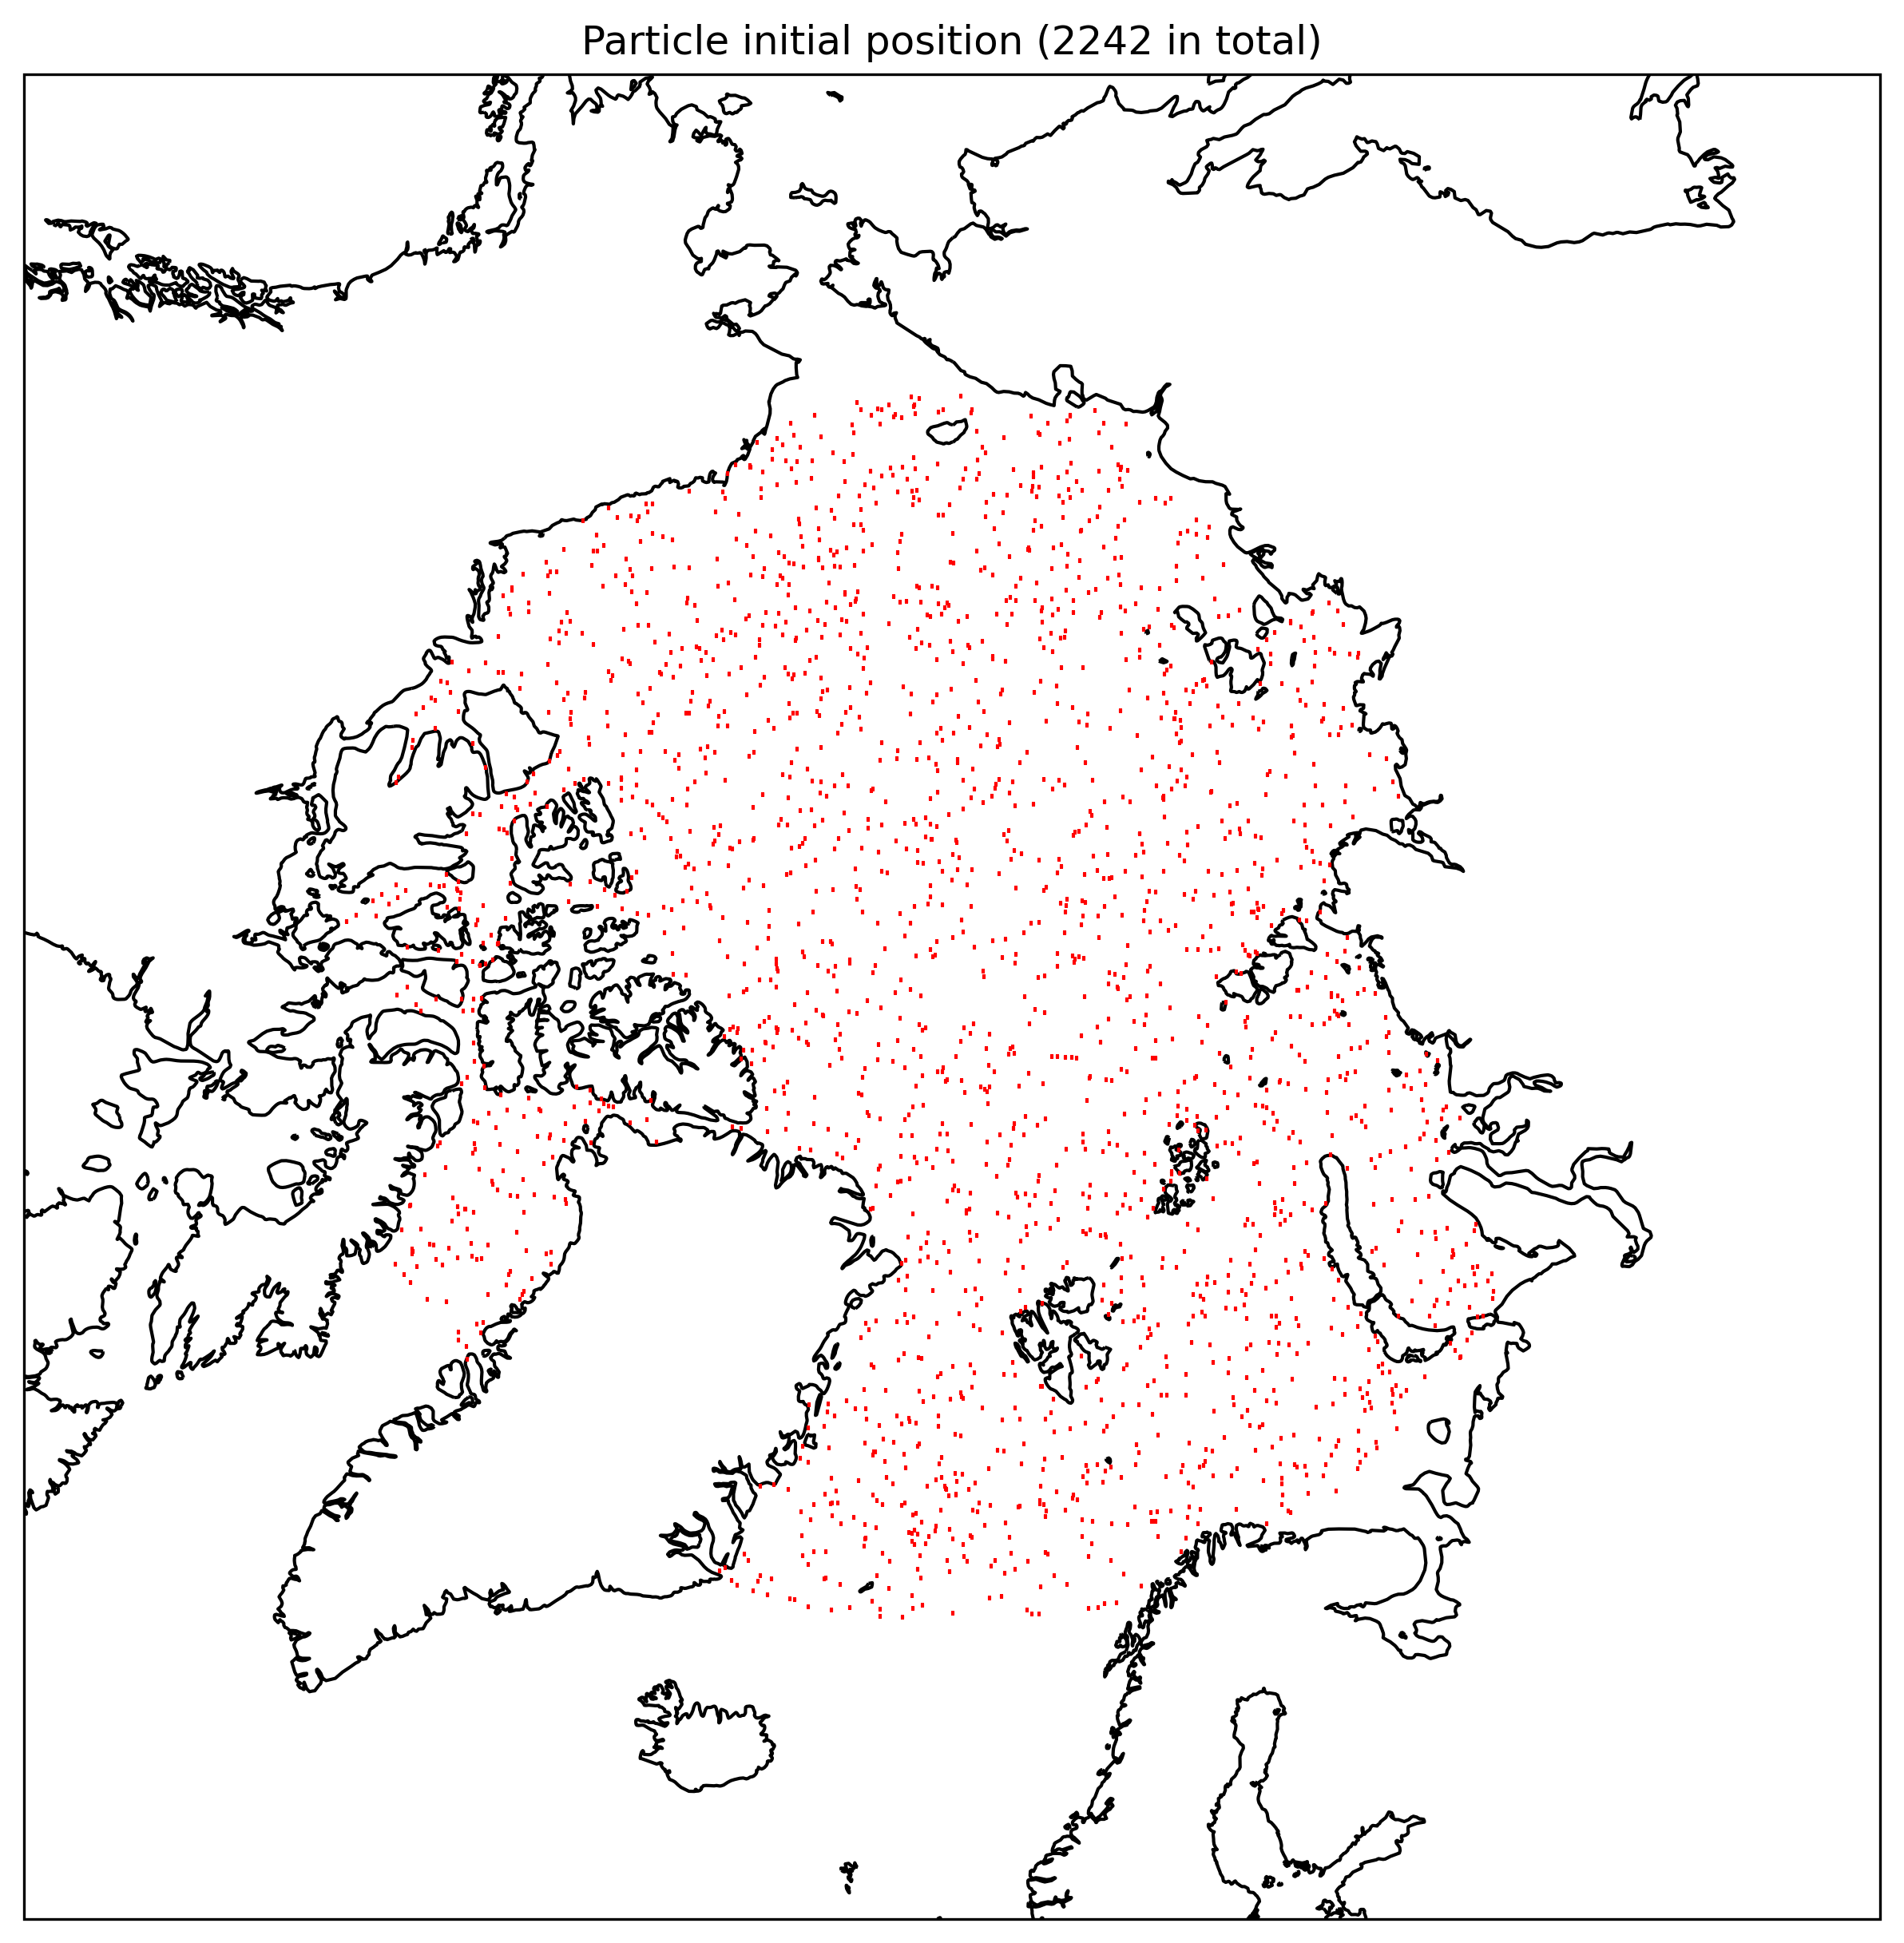

In [10]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
ax.plot(p.lon, p.lat, "r+", markersize=1, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
ax.set_title(f"Particle initial position ({p.N} in total)")
plt.show()

## Simulate particles forwards in time

The particles are in position, so it is time to carry out the simulation. Seaduck's Particle object has the <code>.to_list_of_time</code> option, which runs the particle trajectory simulation and returns the particle positions at specified output times. These output times are defined by <code>normal_stops</code>, at 15 regular intervals between the beginning time, <code>t[0]</code>, and the end time, <code>tf</code>. We will generate <code>stops</code>, which is a list of time that corresponds to <code>normal_stops</code>, and <code>raw</code>, which is a list of <code>sd.Position</code> objects, one for each time in <code>stops</code>. 

In [11]:
# Define when to dump output
normal_stops = np.linspace(t[0], tf, 15)

# Simulation!
stops, raw = p.to_list_of_time(normal_stops=normal_stops)

2002-02-01T00:00:00
2002-02-13T22:17:09
2002-02-26T20:34:17
2002-03-11T18:51:26
2002-03-24T17:08:34
2002-04-06T15:25:43
2002-04-19T13:42:51
2002-05-02T12:00:00
2002-05-15T10:17:09
2002-05-28T08:34:17
2002-06-10T06:51:26
2002-06-23T05:08:34
2002-07-06T03:25:43
2002-07-19T01:42:51
2002-08-01T00:00:00


## Plot the trajectories

The simulation is complete! Now it is time to plot the output. First, let's generate an array of latitudes and longitudes from the <code>raw</code> object.

In [12]:
lons = np.array([pt.lon for pt in raw]).T
lats = np.array([pt.lat for pt in raw]).T

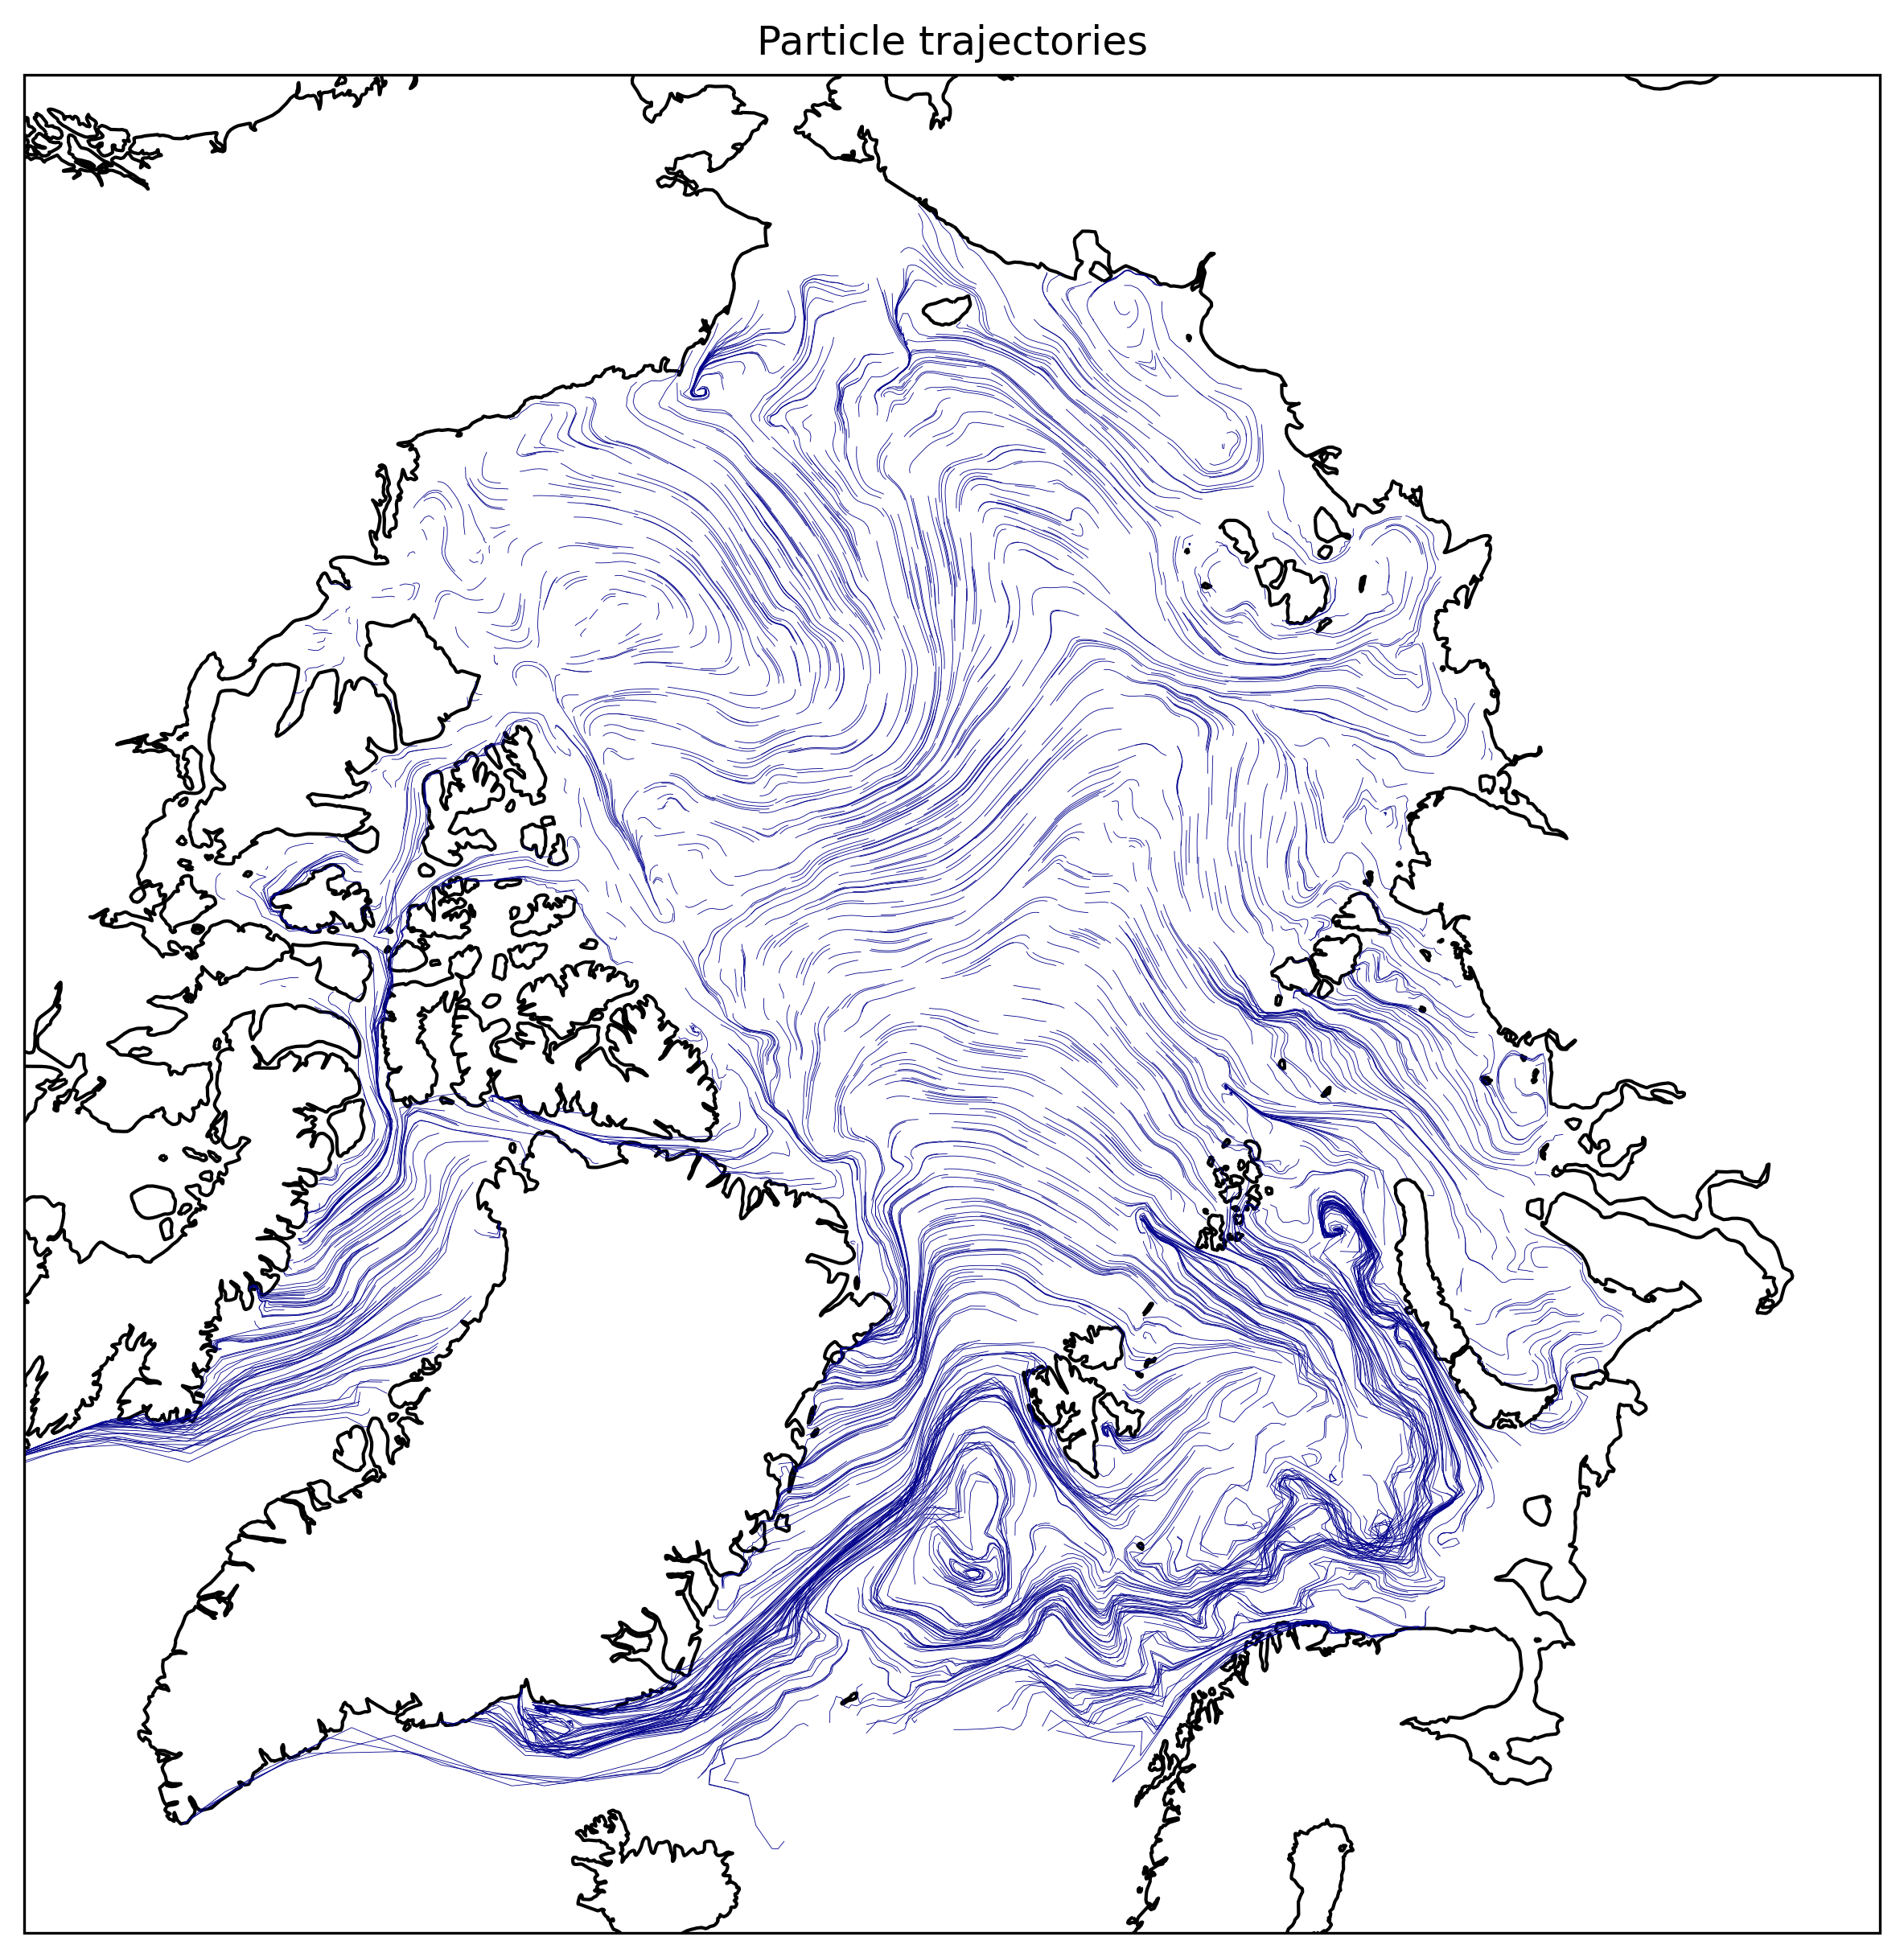

In [13]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
ax.plot(lons.T, lats.T, "darkblue", lw=0.2, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
ax.set_title("Particle trajectories")
plt.show()

Looks good!